<a href="https://colab.research.google.com/github/Kendrick-Choong/awesome-datascience-colleges/blob/master/COMP_4531_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Testing GPU Connectivity
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
# Importing important packages
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from keras.layers import Dropout, Dense, Flatten, BatchNormalization, GlobalAveragePooling2D
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Mount Google Drive w/ Image Data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Unzip image data from Google Drive
!unzip "/content/drive/MyDrive/COMP 4531 Data /archive (2).zip" -d "/content"

Streaming output truncated to the last 5000 lines.
  inflating: /content/img_align_celeba/img_align_celeba/197605.jpg  
  inflating: /content/img_align_celeba/img_align_celeba/197606.jpg  
  inflating: /content/img_align_celeba/img_align_celeba/197607.jpg  
  inflating: /content/img_align_celeba/img_align_celeba/197608.jpg  
  inflating: /content/img_align_celeba/img_align_celeba/197609.jpg  
  inflating: /content/img_align_celeba/img_align_celeba/197610.jpg  
  inflating: /content/img_align_celeba/img_align_celeba/197611.jpg  
  inflating: /content/img_align_celeba/img_align_celeba/197612.jpg  
  inflating: /content/img_align_celeba/img_align_celeba/197613.jpg  
  inflating: /content/img_align_celeba/img_align_celeba/197614.jpg  
  inflating: /content/img_align_celeba/img_align_celeba/197615.jpg  
  inflating: /content/img_align_celeba/img_align_celeba/197616.jpg  
  inflating: /content/img_align_celeba/img_align_celeba/197617.jpg  
  inflating: /content/img_align_celeba/img_align_cel

In [5]:
# Read in attribute data from csv
df = pd.read_csv('/content/list_attr_celeba.csv')
df.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [6]:
# Grabbing columns only required for the CNN.
df = df[['image_id','Bald','Black_Hair','Blond_Hair','Brown_Hair','Gray_Hair']]
df = df.loc[(df==1).any(axis=1)]
df.reset_index(drop=True, inplace=True)
df.head()

,image_id,Bald,Black_Hair,Blond_Hair,Brown_Hair,Gray_Hair
0,000001.jpg,-1,-1,-1,1,-1
1,000002.jpg,-1,-1,-1,1,-1
2,000006.jpg,-1,-1,-1,1,-1
3,000007.jpg,-1,1,-1,-1,-1
4,000008.jpg,-1,1,-1,-1,-1


In [7]:
# Defining categories to assign a single color to an image.
def color_label(row):
  if row['Bald'] == 1:
    return 'Bald'
  if row['Black_Hair'] == 1:
    return 'Black'
  if row['Blond_Hair'] == 1:
    return 'Black'
  if row['Brown_Hair'] == 1:
    return 'Brown'
  if row['Gray_Hair'] == 1:
    return 'Gray'

df['Color'] = df.apply(color_label, axis=1)
df = df[['image_id','Color']]
df.head()

,image_id,Color
0,000001.jpg,Brown
1,000002.jpg,Brown
2,000006.jpg,Brown
3,000007.jpg,Black
4,000008.jpg,Black


In [8]:
import os
from functools import partial

# Make directories to store the training data for the data generators.
root_directory = 'dataset'

list = ['Bald','Black','Blonde',
        'Gray', 'Brown']

concat_root_path = partial(os.path.join, root_directory)
make_directory = partial(os.makedirs, exist_ok=True)

for path_items in map(concat_root_path, list):
    make_directory(path_items)

In [9]:
# Moving all the files from each directory.
for i in range(0,len(df)):
  os.rename(f'/content/img_align_celeba/img_align_celeba/{df["image_id"][i]}', f'/content/dataset/{df["Color"][i]}/{df["image_id"][i]}')

In [10]:
# Viewing the folder in the 'dataset' directory.
data_dir = 'dataset'
Name = os.listdir(data_dir)

print(Name)
print(len(Name))

['Blonde', 'Brown', 'Black', 'Bald', 'Gray']
5


In [11]:
# Creating basic data generators with no image augmentation with a starting batch size of 32 and rescale the images with a validation split.
preprocess_input = tf.keras.applications.resnet.preprocess_input

train_datagen = ImageDataGenerator(rescale = 1./255,validation_split=0.2)

validation_datagen = ImageDataGenerator(rescale = 1./255,validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(255,255),
    class_mode='categorical',
  batch_size=32,subset = "training")

validation_generator = validation_datagen.flow_from_directory(
    data_dir,
    target_size=(255,255),
    class_mode='categorical',
  batch_size=32,subset = "validation")

Found 103186 images belonging to 5 classes.
Found 25794 images belonging to 5 classes.


In [12]:
# Baseline Inception V3 Model
from keras.applications.inception_v3 import InceptionV3
pre_trained_model = InceptionV3(input_shape = (255, 255, 3), include_top = False, weights="imagenet")
# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False
# printing out the summary of the pretrained model
pre_trained_model.summary()
# getting the last layer from the pre_trained model to use for traning
last_layer = pre_trained_model.get_layer('mixed10')
last_output = last_layer.output
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(last_output)
x = layers.GlobalAveragePooling2D()(x)
# Flattening the model to 1 dimension
x = layers.Flatten()(x)
# Add a final sigmoid layer for classification
x = layers.Dense(5, activation='softmax')(x)
# Append the dense network to the base model
model = Model(pre_trained_model.input, x)
# Print the model summary. See your dense network connected at the end.
model.summary()
# compiling the model
model.compile(optimizer = RMSprop(learning_rate=0.001),
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])
# Adding early stopping
callbacks_list = [ keras.callbacks.EarlyStopping( monitor="val_accuracy", patience=5, ),
                  keras.callbacks.ModelCheckpoint( filepath="checkpoint_path.keras", monitor="val_loss", save_best_only=True, ) ]

# Fitting the model
history = model.fit( train_generator, validation_data = validation_generator, steps_per_epoch = 81, epochs = 30, callbacks = callbacks_list)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 255, 255, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 127, 127, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 127, 127, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 127, 127, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 125, 125, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 125, 125, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 125, 125, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 125, 125, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 125, 125, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 125, 125, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 62, 62, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 62, 62, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 62, 62, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 62, 62, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 60, 60, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 60, 60, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 255, 255, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 127, 127, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 127, 127, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 127, 127, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 125, 125, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 125, 125, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 125, 125, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 125, 125, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 125, 125, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 125, 125, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 62, 62, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 62, 62, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 62, 62, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 62, 62, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 60, 60, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 60, 60, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 23,906,085 (91.19 MB)

 Trainable params: 2,103,301 (8.02 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:567: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


81/81 ━━━━━━━━━━━━━━━━━━━━ 67s 604ms/step - accuracy: 0.5557 - loss: 1.9663 - val_accuracy: 0.6968 - val_loss: 0.6816
Epoch 2/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 42s 527ms/step - accuracy: 0.6752 - loss: 0.6936 - val_accuracy: 0.7095 - val_loss: 0.5870
Epoch 3/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 34s 421ms/step - accuracy: 0.7234 - loss: 0.5921 - val_accuracy: 0.5176 - val_loss: 0.9383
Epoch 4/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 36s 447ms/step - accuracy: 0.7337 - loss: 0.5822 - val_accuracy: 0.7874 - val_loss: 0.5178
Epoch 5/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 33s 418ms/step - accuracy: 0.7667 - loss: 0.5276 - val_accuracy: 0.7301 - val_loss: 0.5661
Epoch 6/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 35s 440ms/step - accuracy: 0.7928 - loss: 0.5070 - val_accuracy: 0.7673 - val_loss: 0.5274
Epoch 7/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 33s 414ms/step - accuracy: 0.7931 - loss: 0.4760 - val_accuracy: 0.7727 - val_loss: 0.5185
Epoch 8/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 34s 423ms/step - accuracy: 0.8010 - loss: 0.4631 - val_accuracy: 0.726

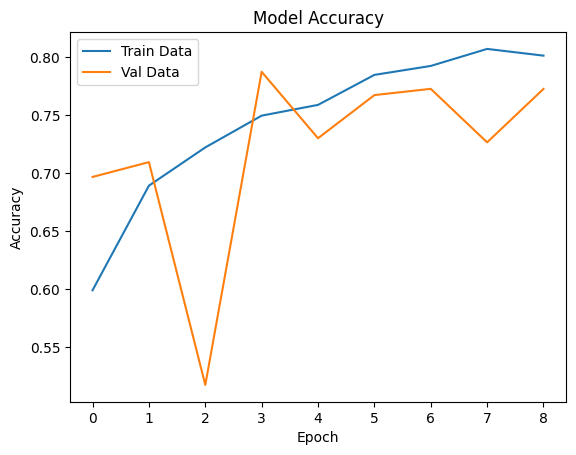

In [13]:
# Plotting accuracy for train and validation data for the model.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Data', 'Val Data'], loc='upper left')
plt.show()

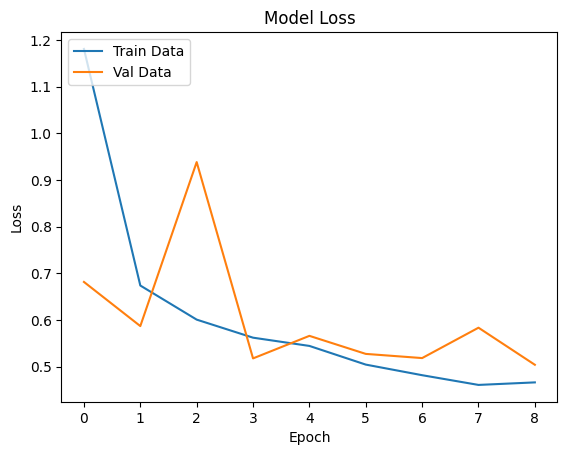

In [14]:
# Plotting loss for train and validation data for the model.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Data', 'Val Data'], loc='upper left')
plt.show()

In [15]:
# Evaluating the model using the validation data.
scores_baseline_inception = model.evaluate(validation_generator)
print("%s%s: %.2f%%" % ("evaluate ",model.metrics_names[1], scores_baseline_inception[1]*100))

# Making predictions
x_batch, y_batch = next(validation_generator)

predictions_baseline_inception = model.predict(x_batch)
classes_baseline_inception = np.argmax(predictions_baseline_inception, axis = 1)

807/807 ━━━━━━━━━━━━━━━━━━━━ 33s 41ms/step - accuracy: 0.7769 - loss: 0.4942
evaluate compile_metrics: 77.26%
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [16]:
# Baseline VGG19 Model
from keras.applications.vgg19 import VGG19
pre_trained_model = VGG19(input_shape = (255, 255, 3), include_top = False, weights="imagenet")
# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False
# printing out the summary of the pretrained model
pre_trained_model.summary()
# getting the last layer from the pre_trained model to use for traning
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(last_output)
x = layers.GlobalAveragePooling2D()(x)
# Flattening the model to 1 dimension
x = layers.Flatten()(x)
# Add a final sigmoid layer for classification
x = layers.Dense(5, activation='softmax')(x)
# Append the dense network to the base model
model = Model(pre_trained_model.input, x)
# Print the model summary. See your dense network connected at the end.
model.summary()
# compiling the model
model.compile(optimizer = RMSprop(learning_rate=0.001),
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

# Adding early stopping
callbacks_list = [ keras.callbacks.EarlyStopping( monitor="val_accuracy", patience=5, ),
                  keras.callbacks.ModelCheckpoint( filepath="checkpoint_path.keras", monitor="val_loss", save_best_only=True, ) ]

# Fitting the model
history = model.fit( train_generator, validation_data = validation_generator, steps_per_epoch = 81, epochs = 30, callbacks = callbacks_list)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 255, 255, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 255, 255, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 255, 255, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 127, 127, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 127, 127, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 127, 127, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 63, 63, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 63, 63, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 63, 63, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 63, 63, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 63, 63, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 31, 31, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 31, 31, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 31, 31, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 31, 31, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 31, 31, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 15, 15, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 255, 255, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 255, 255, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 255, 255, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 127, 127, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 127, 127, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 127, 127, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 63, 63, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 63, 63, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 63, 63, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 63, 63, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 63, 63, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 31, 31, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 31, 31, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 31, 31, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 31, 31, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 31, 31, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 15, 15, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,554,821 (78.41 MB)

 Trainable params: 530,437 (2.02 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

Epoch 1/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 46s 478ms/step - accuracy: 0.5291 - loss: 1.0971 - val_accuracy: 0.6096 - val_loss: 0.8477
Epoch 2/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 33s 418ms/step - accuracy: 0.6009 - loss: 0.8818 - val_accuracy: 0.5973 - val_loss: 0.8467
Epoch 3/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 35s 436ms/step - accuracy: 0.6089 - loss: 0.8214 - val_accuracy: 0.6657 - val_loss: 0.7494
Epoch 4/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 35s 443ms/step - accuracy: 0.6322 - loss: 0.7766 - val_accuracy: 0.6288 - val_loss: 0.8499
Epoch 5/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 37s 465ms/step - accuracy: 0.6293 - loss: 0.7565 - val_accuracy: 0.7015 - val_loss: 0.6813
Epoch 6/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 34s 421ms/step - accuracy: 0.6704 - loss: 0.7068 - val_accuracy: 0.5930 - val_loss: 0.8069
Epoch 7/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 32s 402ms/step - accuracy: 0.6729 - loss: 0.6950 - val_accuracy: 0.6469 - val_loss: 0.7053
Epoch 8/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 35s 434ms/step - accuracy: 0.6672 - loss: 0.7139 - val_accu

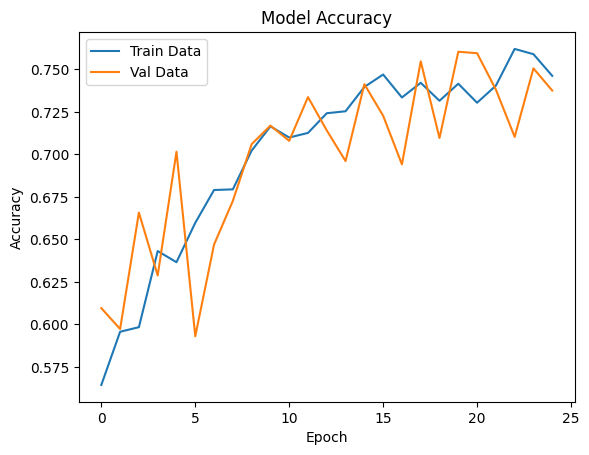

In [17]:
# Plotting accuracy for train and validation data for the model.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Data', 'Val Data'], loc='upper left')
plt.show()

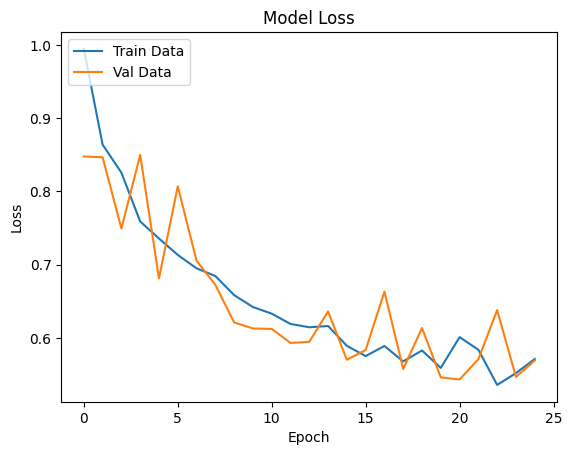

In [18]:
# Plotting loss for train and validation data for the model.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Data', 'Val Data'], loc='upper left')
plt.show()

In [19]:
# Evaluating the model using the validation data.
scores_baseline_vgg = model.evaluate(validation_generator)
print("%s%s: %.2f%%" % ("evaluate ",model.metrics_names[1], scores_baseline_vgg[1]*100))

# Making predictions
x_batch, y_batch = next(validation_generator)

predictions_baseline_vgg = model.predict(x_batch)
classes_baseline_vgg = np.argmax(predictions_baseline_vgg, axis = 1)

807/807 ━━━━━━━━━━━━━━━━━━━━ 33s 40ms/step - accuracy: 0.7380 - loss: 0.5661
evaluate compile_metrics: 73.75%
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


In [20]:
# Creating new data generators based on a batch size of 64.
preprocess_input = tf.keras.applications.resnet.preprocess_input

train_datagen = ImageDataGenerator(rescale = 1./255,validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(255,255),
    class_mode='categorical',
  batch_size=64,subset = "training")

validation_datagen = ImageDataGenerator(rescale = 1./255,validation_split=0.2)

validation_generator = validation_datagen.flow_from_directory(
    data_dir,
    target_size=(255,255),
    class_mode='categorical',
  batch_size=64,subset = "validation")

Found 103186 images belonging to 5 classes.
Found 25794 images belonging to 5 classes.


In [21]:
# Inception V3 Model w/ batch size of 64.
pre_trained_model = InceptionV3(input_shape = (255, 255, 3), include_top = False, weights="imagenet")
# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False
# getting the last layer from the pre_trained model to use for traning
last_layer = pre_trained_model.get_layer('mixed10')
last_output = last_layer.output
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(last_output)
x = layers.GlobalAveragePooling2D()(x)
# Flattening the model to 1 dimension
x = layers.Flatten()(x)
# Add a final sigmoid layer for classification
x = layers.Dense(5, activation='softmax')(x)
# Append the dense network to the base model
model = Model(pre_trained_model.input, x)

# compiling the model
model.compile(optimizer = RMSprop(learning_rate=0.001),
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

# Adding early stopping
callbacks_list = [ keras.callbacks.EarlyStopping( monitor="val_accuracy", patience=5, ),
                  keras.callbacks.ModelCheckpoint( filepath="checkpoint_path.keras", monitor="val_loss", save_best_only=True, ) ]

# Fitting the model
history = model.fit( train_generator, validation_data = validation_generator, steps_per_epoch = 81, epochs = 30, callbacks = callbacks_list)

Epoch 1/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 73s 667ms/step - accuracy: 0.5601 - loss: 1.8829 - val_accuracy: 0.6739 - val_loss: 0.6921
Epoch 2/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 46s 569ms/step - accuracy: 0.6817 - loss: 0.6683 - val_accuracy: 0.6886 - val_loss: 0.6084
Epoch 3/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 48s 597ms/step - accuracy: 0.7482 - loss: 0.5595 - val_accuracy: 0.7713 - val_loss: 0.5061
Epoch 4/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 47s 583ms/step - accuracy: 0.7588 - loss: 0.5320 - val_accuracy: 0.7952 - val_loss: 0.4801
Epoch 5/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 47s 581ms/step - accuracy: 0.7958 - loss: 0.4822 - val_accuracy: 0.8079 - val_loss: 0.4640
Epoch 6/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 43s 539ms/step - accuracy: 0.8112 - loss: 0.4513 - val_accuracy: 0.8114 - val_loss: 0.4479
Epoch 7/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 39s 485ms/step - accuracy: 0.8097 - loss: 0.4740 - val_accuracy: 0.7867 - val_loss: 0.4831
Epoch 8/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 42s 521ms/step - accuracy: 0.8119 - loss: 0.4425 - val_accu

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


81/81 ━━━━━━━━━━━━━━━━━━━━ 41s 510ms/step - accuracy: 0.8372 - loss: 0.3887 - val_accuracy: 0.8207 - val_loss: 0.4420
Epoch 21/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 47s 578ms/step - accuracy: 0.8384 - loss: 0.3845 - val_accuracy: 0.8365 - val_loss: 0.3993
Epoch 22/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 44s 547ms/step - accuracy: 0.8425 - loss: 0.3715 - val_accuracy: 0.8169 - val_loss: 0.4344
Epoch 23/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 44s 553ms/step - accuracy: 0.8382 - loss: 0.3886 - val_accuracy: 0.8329 - val_loss: 0.4110
Epoch 24/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 46s 571ms/step - accuracy: 0.8326 - loss: 0.4082 - val_accuracy: 0.8398 - val_loss: 0.3880


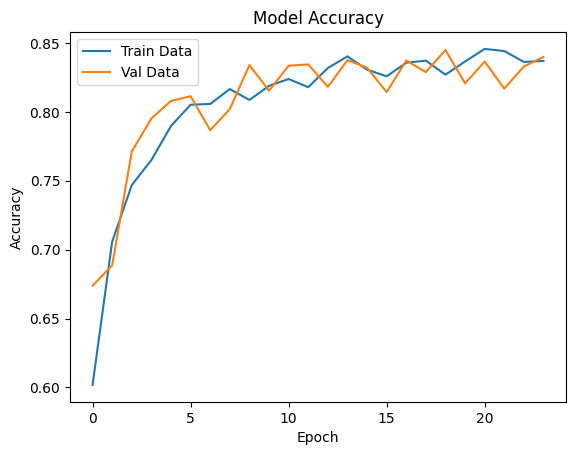

In [22]:
# Plotting accuracy for train and validation data for the model.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Data', 'Val Data'], loc='upper left')
plt.show()

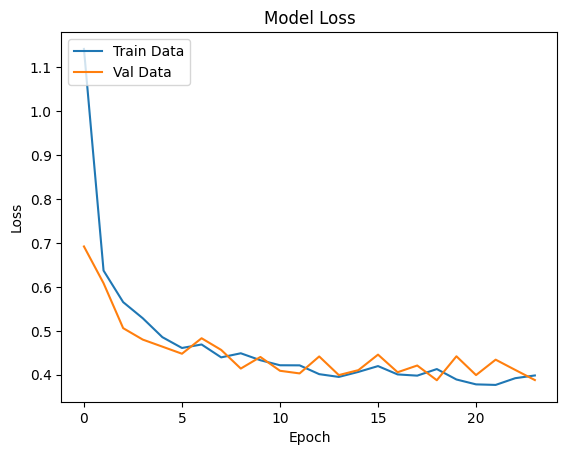

In [23]:
# Plotting loss for train and validation data for the model.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Data', 'Val Data'], loc='upper left')
plt.show()

In [24]:
# Evaluating the model using the validation data.
scores_inception_64 = model.evaluate(validation_generator)
print("%s%s: %.2f%%" % ("evaluate ",model.metrics_names[1], scores_inception_64[1]*100))

# Making predictions
x_batch, y_batch = next(validation_generator)

predictions_inception_64 = model.predict(x_batch)
classes_inception_64 = np.argmax(predictions_inception_64, axis = 1)

404/404 ━━━━━━━━━━━━━━━━━━━━ 38s 95ms/step - accuracy: 0.8431 - loss: 0.3879
evaluate compile_metrics: 83.98%
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step


In [25]:
# Creating new data generators based on a batch size of 128.
preprocess_input = tf.keras.applications.resnet.preprocess_input

train_datagen = ImageDataGenerator(rescale = 1./255,validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(255,255),
    class_mode='categorical',
  batch_size=128,subset = "training")

validation_datagen = ImageDataGenerator(rescale = 1./255,validation_split=0.2)

validation_generator = validation_datagen.flow_from_directory(
    data_dir,
    target_size=(255,255),
    class_mode='categorical',
  batch_size=128,subset = "validation")

Found 103186 images belonging to 5 classes.
Found 25794 images belonging to 5 classes.


In [26]:
# Inception V3 Model w/ batch size of 128.
pre_trained_model = InceptionV3(input_shape = (255, 255, 3), include_top = False, weights="imagenet")
# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False
# getting the last layer from the pre_trained model to use for traning
last_layer = pre_trained_model.get_layer('mixed10')
#print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(last_output)
x = layers.GlobalAveragePooling2D()(x)
# Flattening the model to 1 dimension
x = layers.Flatten()(x)
# Add a final sigmoid layer for classification
x = layers.Dense(5, activation='softmax')(x)
# Append the dense network to the base model
model = Model(pre_trained_model.input, x)

# compiling the model
model.compile(optimizer = RMSprop(learning_rate=0.001),
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

# Adding early stopping
callbacks_list = [ keras.callbacks.EarlyStopping( monitor="val_accuracy", patience=5, ),
                  keras.callbacks.ModelCheckpoint( filepath="checkpoint_path.keras", monitor="val_loss", save_best_only=True, ) ]

# Fitting the model
history = model.fit( train_generator, validation_data = validation_generator, steps_per_epoch = 81, epochs = 30, callbacks = callbacks_list)

Epoch 1/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 92s 864ms/step - accuracy: 0.5071 - loss: 2.6038 - val_accuracy: 0.6936 - val_loss: 0.6752
Epoch 2/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 55s 682ms/step - accuracy: 0.6825 - loss: 0.6690 - val_accuracy: 0.7715 - val_loss: 0.5268
Epoch 3/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 54s 675ms/step - accuracy: 0.7561 - loss: 0.5494 - val_accuracy: 0.8048 - val_loss: 0.4729
Epoch 4/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 53s 666ms/step - accuracy: 0.7833 - loss: 0.4986 - val_accuracy: 0.7993 - val_loss: 0.4802
Epoch 5/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 52s 655ms/step - accuracy: 0.7944 - loss: 0.4669 - val_accuracy: 0.8178 - val_loss: 0.4334
Epoch 6/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 53s 667ms/step - accuracy: 0.8097 - loss: 0.4507 - val_accuracy: 0.8229 - val_loss: 0.4314
Epoch 7/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 45s 566ms/step - accuracy: 0.8068 - loss: 0.4447 - val_accuracy: 0.8084 - val_loss: 0.4441
Epoch 8/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 47s 585ms/step - accuracy: 0.8160 - loss: 0.4452 - val_accu

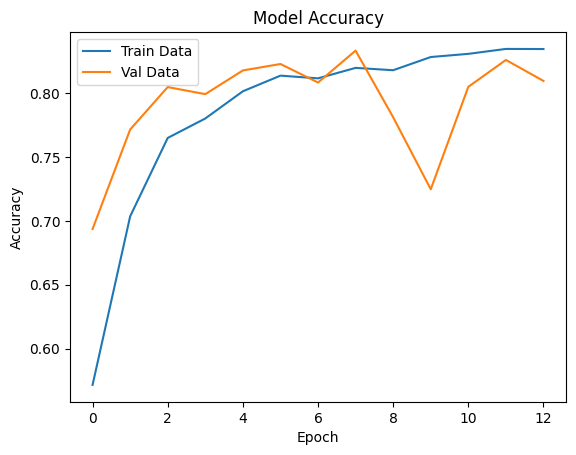

In [27]:
# Plotting accuracy for train and validation data for the model.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Data', 'Val Data'], loc='upper left')
plt.show()

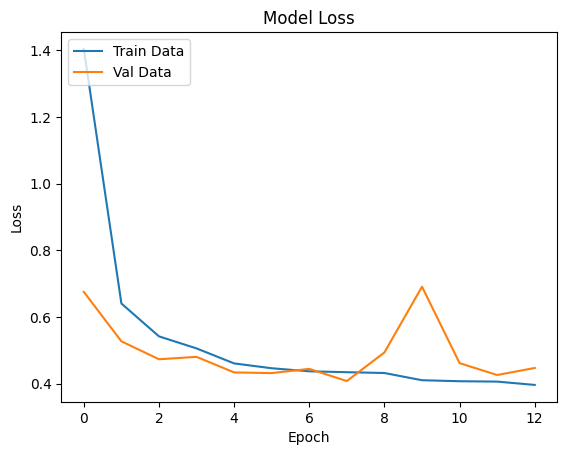

In [28]:
# Plotting loss for train and validation data for the model.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Data', 'Val Data'], loc='upper left')
plt.show()

In [29]:
# Evaluating the model using the validation data.
scores_inception_128 = model.evaluate(validation_generator)
print("%s%s: %.2f%%" % ("evaluate ",model.metrics_names[1], scores_inception_128[1]*100))

# Making predictions
x_batch, y_batch = next(validation_generator)

predictions_inception_128 = model.predict(x_batch)
classes_inception_128 = np.argmax(predictions_inception_128, axis = 1)

202/202 ━━━━━━━━━━━━━━━━━━━━ 39s 191ms/step - accuracy: 0.8087 - loss: 0.4463
evaluate compile_metrics: 80.96%
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step


In [30]:
# Creating new data generators based on a batch size of 256.
preprocess_input = tf.keras.applications.resnet.preprocess_input

train_datagen = ImageDataGenerator(rescale = 1./255,validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(255,255),
    class_mode='categorical',
  batch_size=256,subset = "training")

validation_datagen = ImageDataGenerator(rescale = 1./255,validation_split=0.2)

validation_generator = validation_datagen.flow_from_directory(
    data_dir,
    target_size=(255,255),
    class_mode='categorical',
  batch_size=256,subset = "validation")

Found 103186 images belonging to 5 classes.
Found 25794 images belonging to 5 classes.


In [31]:
# Inception V3 Model w/ batch size of 256.
pre_trained_model = InceptionV3(input_shape = (255, 255, 3), include_top = False, weights="imagenet")
# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False
# getting the last layer from the pre_trained model to use for traning
last_layer = pre_trained_model.get_layer('mixed10')
#print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(last_output)
x = layers.GlobalAveragePooling2D()(x)
# Flattening the model to 1 dimension
x = layers.Flatten()(x)
# Add a final sigmoid layer for classification
x = layers.Dense(5, activation='softmax')(x)
# Append the dense network to the base model
model = Model(pre_trained_model.input, x)

# compiling the model
model.compile(optimizer = RMSprop(learning_rate=0.001),
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

# Adding early stopping
callbacks_list = [ keras.callbacks.EarlyStopping( monitor="val_accuracy", patience=5, ),
                  keras.callbacks.ModelCheckpoint( filepath="checkpoint_path.keras", monitor="val_loss", save_best_only=True, ) ]

# Fitting the model
history = model.fit( train_generator, validation_data = validation_generator, steps_per_epoch = 81, epochs = 30, callbacks = callbacks_list)

Epoch 1/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.5061 - loss: 2.4826 - val_accuracy: 0.6167 - val_loss: 0.7978
Epoch 2/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 67s 836ms/step - accuracy: 0.6678 - loss: 0.6942 - val_accuracy: 0.7691 - val_loss: 0.5054
Epoch 3/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 68s 849ms/step - accuracy: 0.7482 - loss: 0.5508 - val_accuracy: 0.7934 - val_loss: 0.4931
Epoch 4/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 66s 824ms/step - accuracy: 0.7836 - loss: 0.5006 - val_accuracy: 0.8148 - val_loss: 0.4376
Epoch 5/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 60s 754ms/step - accuracy: 0.8007 - loss: 0.4590 - val_accuracy: 0.8269 - val_loss: 0.4167
Epoch 6/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 70s 835ms/step - accuracy: 0.8120 - loss: 0.4448 - val_accuracy: 0.8242 - val_loss: 0.4206
Epoch 7/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 68s 850ms/step - accuracy: 0.8225 - loss: 0.4207 - val_accuracy: 0.8345 - val_loss: 0.4053
Epoch 8/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 67s 837ms/step - accuracy: 0.8286 - loss: 0.4177 - val_accura

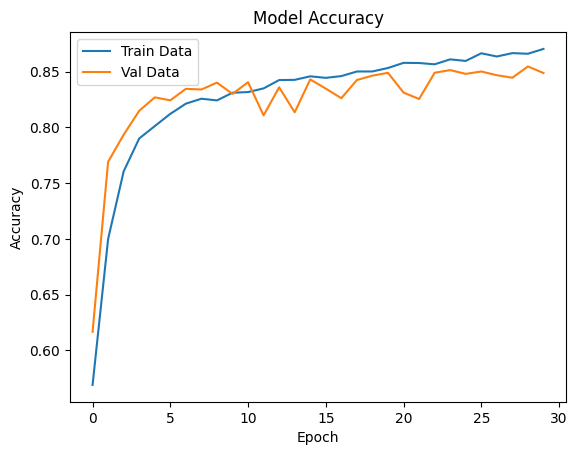

In [32]:
# Plotting accuracy for train and validation data for the model.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Data', 'Val Data'], loc='upper left')
plt.show()

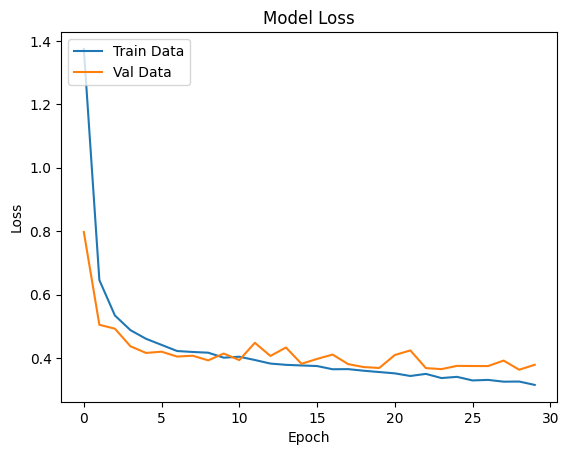

In [33]:
# Plotting loss for train and validation data for the model.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Data', 'Val Data'], loc='upper left')
plt.show()

In [34]:
# Evaluating the model using the validation data.
scores_inception_256 = model.evaluate(validation_generator)
print("%s%s: %.2f%%" % ("evaluate ",model.metrics_names[1], scores_inception_256[1]*100))

# Making predictions
x_batch, y_batch = next(validation_generator)

predictions_inception_256 = model.predict(x_batch)
classes_inception_256 = np.argmax(predictions_inception_256, axis = 1)

101/101 ━━━━━━━━━━━━━━━━━━━━ 37s 366ms/step - accuracy: 0.8498 - loss: 0.3747
evaluate compile_metrics: 84.87%


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step


In [35]:
# Adding in a dropout layer to help reduce overfitting for a batch size of 256.
# Inception V3 Model w/ BS of 256 and dropout of 0.2.
pre_trained_model = InceptionV3(input_shape = (255, 255, 3), include_top = False, weights="imagenet")
# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False
# getting the last layer from the pre_trained model to use for traning
last_layer = pre_trained_model.get_layer('mixed10')
#print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(last_output)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
x = layers.GlobalAveragePooling2D()(x)
# Flattening the model to 1 dimension
x = layers.Flatten()(x)
# Add a final sigmoid layer for classification
x = layers.Dense(5, activation='softmax')(x)
# Append the dense network to the base model
model = Model(pre_trained_model.input, x)
# compiling the model
model.compile(optimizer = RMSprop(learning_rate=0.001),
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

# Adding early stopping
callbacks_list = [ keras.callbacks.EarlyStopping( monitor="val_accuracy", patience=5, ),
                  keras.callbacks.ModelCheckpoint( filepath="checkpoint_path.keras", monitor="val_loss", save_best_only=True, ) ]

# Fitting the model
history = model.fit( train_generator, validation_data = validation_generator, steps_per_epoch = 81, epochs = 30, callbacks = callbacks_list)

Epoch 1/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 89s 932ms/step - accuracy: 0.5372 - loss: 2.2501 - val_accuracy: 0.6981 - val_loss: 0.6161
Epoch 2/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 67s 840ms/step - accuracy: 0.6927 - loss: 0.6547 - val_accuracy: 0.7699 - val_loss: 0.5098
Epoch 3/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 68s 845ms/step - accuracy: 0.7528 - loss: 0.5423 - val_accuracy: 0.8100 - val_loss: 0.4589
Epoch 4/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 67s 830ms/step - accuracy: 0.7863 - loss: 0.4884 - val_accuracy: 0.8196 - val_loss: 0.4337
Epoch 5/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 59s 741ms/step - accuracy: 0.7973 - loss: 0.4697 - val_accuracy: 0.7171 - val_loss: 0.6023
Epoch 6/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 71s 848ms/step - accuracy: 0.8055 - loss: 0.4524 - val_accuracy: 0.8291 - val_loss: 0.4120
Epoch 7/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 68s 845ms/step - accuracy: 0.8167 - loss: 0.4366 - val_accuracy: 0.8328 - val_loss: 0.4033
Epoch 8/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 68s 847ms/step - accuracy: 0.8196 - loss: 0.4200 - val_accu

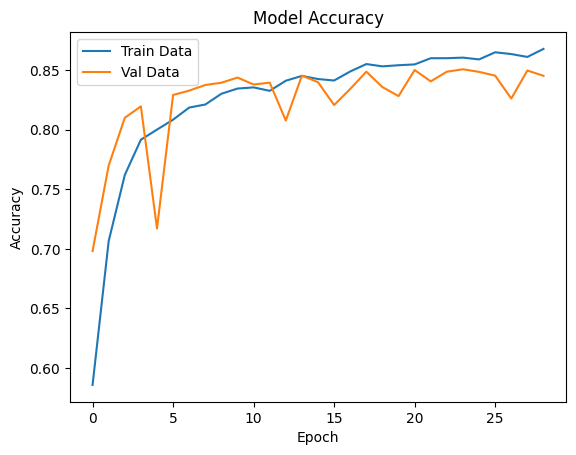

In [36]:
# Plotting accuracy for train and validation data for the model.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Data', 'Val Data'], loc='upper left')
plt.show()

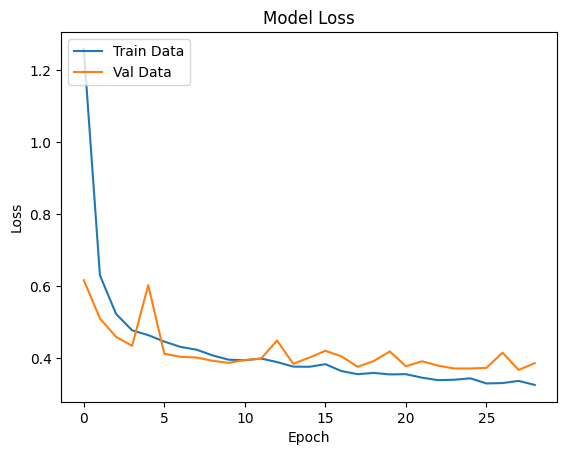

In [37]:
# Plotting loss for train and validation data for the model.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Data', 'Val Data'], loc='upper left')
plt.show()

In [38]:
# Evaluating the model using the validation data.
scores_inception_256_drop = model.evaluate(validation_generator)
print("%s%s: %.2f%%" % ("evaluate ",model.metrics_names[1], scores_inception_256_drop[1]*100))

# Making predictions
x_batch, y_batch = next(validation_generator)

predictions_inception_256_drop = model.predict(x_batch)
classes_inception_256_drop = np.argmax(predictions_inception_256_drop, axis = 1)

101/101 ━━━━━━━━━━━━━━━━━━━━ 38s 376ms/step - accuracy: 0.8502 - loss: 0.3754
evaluate compile_metrics: 84.52%
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step


In [39]:
# Changing the optimizer to "adam" to improve overall model accuracy.
# Inception V3 Model w/ BS of 256 and dropout of 0.2 & 'adam' optimizer.
pre_trained_model = InceptionV3(input_shape = (255, 255, 3), include_top = False, weights="imagenet")
# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False
# getting the last layer from the pre_trained model to use for traning
last_layer = pre_trained_model.get_layer('mixed10')
#print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(last_output)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
x = layers.GlobalAveragePooling2D()(x)
# Flattening the model to 1 dimension
x = layers.Flatten()(x)
# Add a final sigmoid layer for classification
x = layers.Dense(5, activation='softmax')(x)
# Append the dense network to the base model
model = Model(pre_trained_model.input, x)

# compiling the model
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

# Adding early stopping
callbacks_list = [ keras.callbacks.EarlyStopping( monitor="val_accuracy", patience=5, ),
                  keras.callbacks.ModelCheckpoint( filepath="checkpoint_path.keras", monitor="val_loss", save_best_only=True, ) ]

# Fitting the model
history = model.fit( train_generator, validation_data = validation_generator, steps_per_epoch = 81, epochs = 30, callbacks = callbacks_list)

Epoch 1/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 89s 922ms/step - accuracy: 0.6143 - loss: 1.0886 - val_accuracy: 0.7540 - val_loss: 0.5458
Epoch 2/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 70s 873ms/step - accuracy: 0.7636 - loss: 0.5322 - val_accuracy: 0.7844 - val_loss: 0.4862
Epoch 3/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 66s 825ms/step - accuracy: 0.7882 - loss: 0.4815 - val_accuracy: 0.8119 - val_loss: 0.4506
Epoch 4/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 65s 817ms/step - accuracy: 0.8030 - loss: 0.4504 - val_accuracy: 0.8209 - val_loss: 0.4283
Epoch 5/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 55s 684ms/step - accuracy: 0.8198 - loss: 0.4180 - val_accuracy: 0.8273 - val_loss: 0.4134
Epoch 6/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 72s 856ms/step - accuracy: 0.8277 - loss: 0.4063 - val_accuracy: 0.8327 - val_loss: 0.4007
Epoch 7/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 69s 857ms/step - accuracy: 0.8377 - loss: 0.3872 - val_accuracy: 0.8365 - val_loss: 0.4006
Epoch 8/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 67s 839ms/step - accuracy: 0.8371 - loss: 0.3906 - val_accu

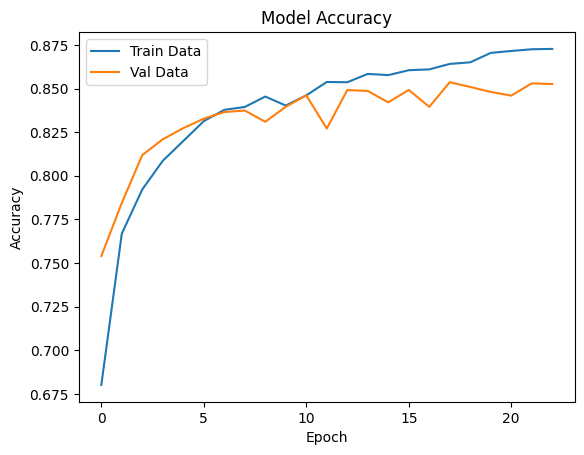

In [40]:
# Plotting accuracy for train and validation data for the model.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Data', 'Val Data'], loc='upper left')
plt.show()

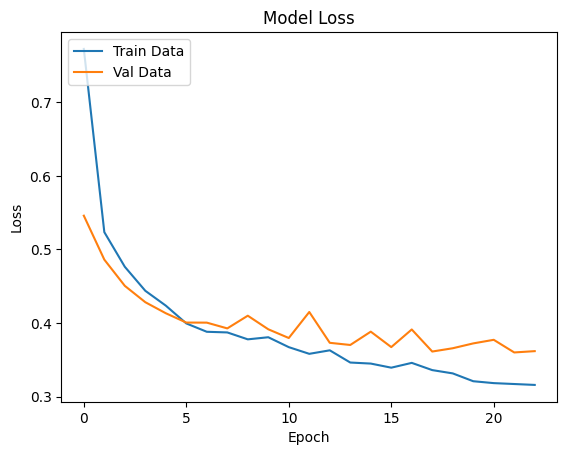

In [41]:
# Plotting loss for train and validation data for the model.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Data', 'Val Data'], loc='upper left')
plt.show()

In [42]:
# Evaluating the model using the validation data.
scores_inception_adam = model.evaluate(validation_generator)
print("%s%s: %.2f%%" % ("evaluate ",model.metrics_names[1], scores_inception_adam[1]*100))

# Making predictions
x_batch, y_batch = next(validation_generator)

predictions_inception_adam = model.predict(x_batch)
classes_inception_adam = np.argmax(predictions_inception_adam, axis = 1)

101/101 ━━━━━━━━━━━━━━━━━━━━ 38s 372ms/step - accuracy: 0.8579 - loss: 0.3540
evaluate compile_metrics: 85.26%
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step


In [43]:
# At higher batch sizes we see better performance but more overfitting so implementing some data augmentation to reduce overfitting.
preprocess_input = tf.keras.applications.resnet.preprocess_input

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(255,255),
    class_mode='categorical',
  batch_size=256,subset = "training")

validation_datagen = ImageDataGenerator(rescale = 1./255,validation_split=0.2)

validation_generator = validation_datagen.flow_from_directory(
    data_dir,
    target_size=(255,255),
    class_mode='categorical',
  batch_size=256,subset = "validation")

Found 103186 images belonging to 5 classes.
Found 25794 images belonging to 5 classes.


In [44]:
# Inception V3 Model w/ data augmentation
pre_trained_model = InceptionV3(input_shape = (255, 255, 3), include_top = False, weights="imagenet")
# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False
# getting the last layer from the pre_trained model to use for traning
last_layer = pre_trained_model.get_layer('mixed10')
#print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(last_output)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
x = layers.GlobalAveragePooling2D()(x)
# Flattening the model to 1 dimension
x = layers.Flatten()(x)
# Add a final sigmoid layer for classification
x = layers.Dense(5, activation='softmax')(x)
# Append the dense network to the base model
model = Model(pre_trained_model.input, x)
# compiling the model
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

# Adding early stopping
callbacks_list = [ keras.callbacks.EarlyStopping( monitor="val_accuracy", patience=5, ),
                  keras.callbacks.ModelCheckpoint( filepath="checkpoint_path.keras", monitor="val_loss", save_best_only=True, ) ]

# Fitting the model
history = model.fit( train_generator, validation_data = validation_generator, steps_per_epoch = 81, epochs = 30, callbacks = callbacks_list)

Epoch 1/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 357s 4s/step - accuracy: 0.5672 - loss: 1.3005 - val_accuracy: 0.7289 - val_loss: 0.6020
Epoch 2/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 312s 4s/step - accuracy: 0.7362 - loss: 0.5829 - val_accuracy: 0.7703 - val_loss: 0.5252
Epoch 3/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 303s 4s/step - accuracy: 0.7716 - loss: 0.5308 - val_accuracy: 0.7900 - val_loss: 0.4818
Epoch 4/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 285s 4s/step - accuracy: 0.7945 - loss: 0.4821 - val_accuracy: 0.8013 - val_loss: 0.4774
Epoch 5/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 254s 3s/step - accuracy: 0.8005 - loss: 0.4754 - val_accuracy: 0.8189 - val_loss: 0.4381
Epoch 6/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 341s 4s/step - accuracy: 0.8064 - loss: 0.4564 - val_accuracy: 0.8158 - val_loss: 0.4360
Epoch 7/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 308s 4s/step - accuracy: 0.8127 - loss: 0.4584 - val_accuracy: 0.8191 - val_loss: 0.4345
Epoch 8/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 306s 4s/step - accuracy: 0.8145 - loss: 0.4404 - val_accuracy: 0.8211 - v

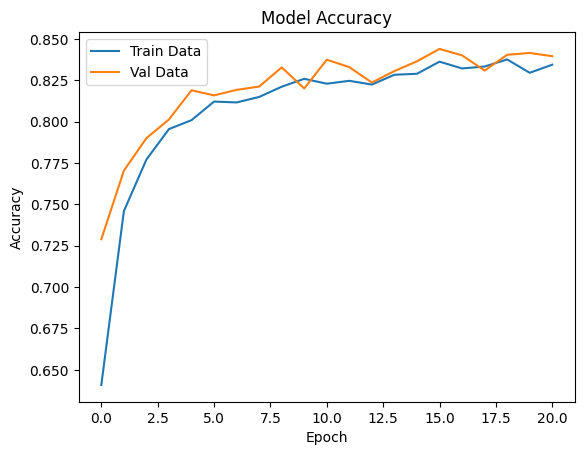

In [45]:
# Plotting accuracy for train and validation data for the model.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Data', 'Val Data'], loc='upper left')
plt.show()

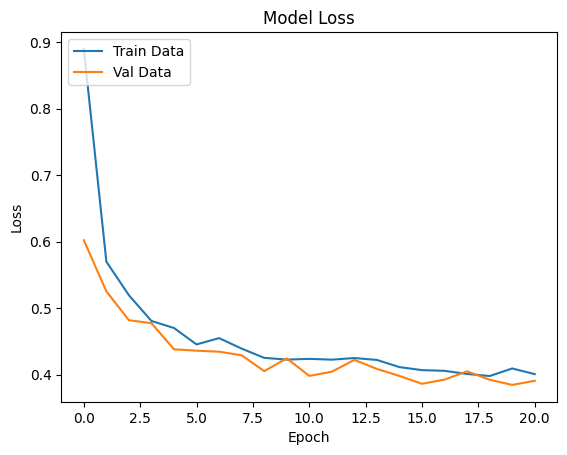

In [46]:
# Plotting loss for train and validation data for the model.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Data', 'Val Data'], loc='upper left')
plt.show()

In [47]:
# Evaluating the model using the validation data.
scores_inception_data_aug = model.evaluate(validation_generator)
print("%s%s: %.2f%%" % ("evaluate ",model.metrics_names[1], scores_inception_data_aug[1]*100))

# Making predictions
x_batch, y_batch = next(validation_generator)

predictions_inception_data_aug = model.predict(x_batch)
classes_inception_data_aug = np.argmax(predictions_inception_data_aug, axis = 1)

101/101 ━━━━━━━━━━━━━━━━━━━━ 38s 373ms/step - accuracy: 0.8392 - loss: 0.3943
evaluate compile_metrics: 83.95%
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step


In [48]:
# import module
from tabulate import tabulate

# assign data
mydata = [
    ["Baseline Inception V3", scores_baseline_inception[1]*100],
    ["Baseline VGG19", scores_baseline_vgg[1]*100],
    ["Inception w/ BS_64", scores_inception_64[1]*100],
    ["Inception w/ BS_128", scores_inception_128[1]*100],
    ["Inception w/ BS_256", scores_inception_256[1]*100],
    ["Inception w/ BS_256 & Dropout", scores_inception_256_drop[1]*100],
    ["Inceoption w/ Adam", scores_inception_adam[1]*100],
    ["Inception w/ Data Augmentation", scores_inception_data_aug[1]*100]

]

# create header
head = ["Model", "Validation Accuracy"]

# display table
print(tabulate(mydata, headers=head, tablefmt="grid"))

+--------------------------------+-----------------------+
| Model                          |   Validation Accuracy |
+================================+=======================+
| Baseline Inception V3          |               77.2622 |
+--------------------------------+-----------------------+
| Baseline VGG19                 |               73.7497 |
+--------------------------------+-----------------------+
| Inception w/ BS_64             |               83.9846 |
+--------------------------------+-----------------------+
| Inception w/ BS_128            |               80.9607 |
+--------------------------------+-----------------------+
| Inception w/ BS_256            |               84.8724 |
+--------------------------------+-----------------------+
| Inception w/ BS_256 & Dropout  |               84.5235 |
+--------------------------------+-----------------------+
| Inceoption w/ Adam             |               85.2563 |
+--------------------------------+----------------------

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
predict:Black, actual:Brown


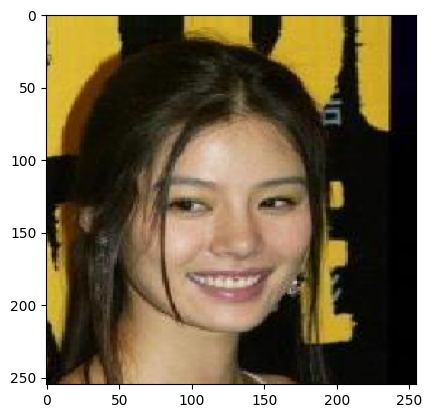

predict:Brown, actual:Black


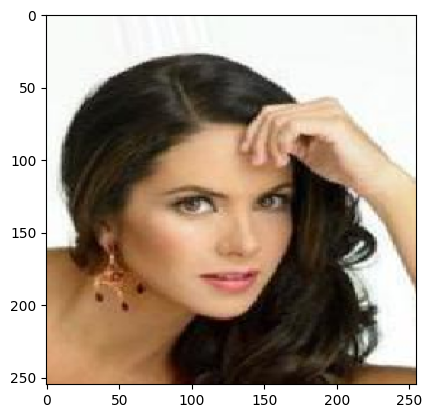

predict:Brown, actual:Brown


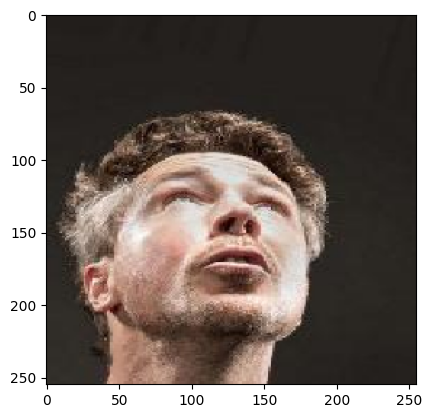

predict:Black, actual:Black


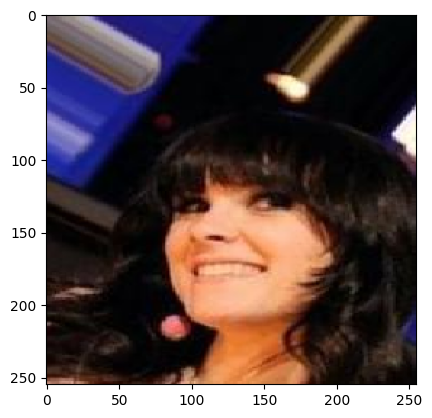

predict:Black, actual:Brown


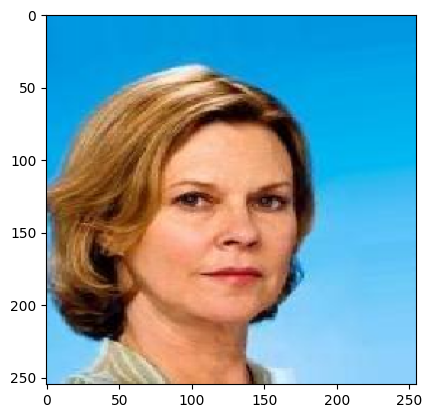

predict:Black, actual:Black


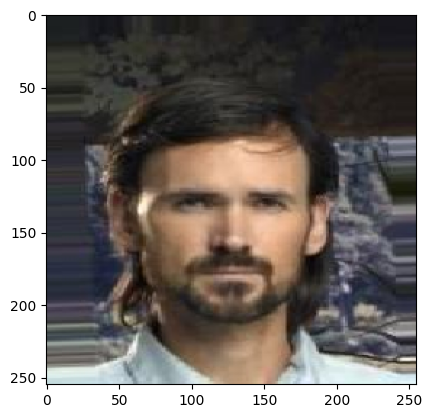

In [50]:
# Making predictions with the best model.
x_batch, y_batch = next(validation_generator)

predictions_inception_adam = model.predict(x_batch)
classes_inception_adam = np.argmax(predictions_inception_adam, axis = 1)

labels = ['Bald','Black','Blonde', 'Brown','Gray']
for i in range (0,6):
    image = x_batch[i]
    predict = labels[classes_inception_adam[i]]
    actual = labels[np.where(y_batch[i] == 1)[0][0]]
    plt.title(print(f'predict:{predict}, actual:{actual}'))
    plt.imshow(image)
    plt.show()